This notebook contains the Exploratory Data Analysis that will feed the Machine Learning Pipeline as well as the app's data visualizations

In [1]:
import pandas as pd
import numpy as np

import sqlalchemy
import os

import seaborn as sns
import matplotlib.pyplot as plt

import phik

from datetime import datetime

# ML
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer, PorterStemmer

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression

import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lucca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lucca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lucca\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
sns.set(rc = {'figure.figsize':(10,7.5)})

In [3]:
conn = sqlalchemy.create_engine('sqlite:///' + os.path.abspath('../data/DisasterResponse.db'))

In [4]:
df = pd.read_sql('SELECT * FROM ANALYTICAL_TABLE', conn)

df.set_index('index', inplace = True)

In [5]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,infered_language,message_cleaned
index,,,,,,,,,,,,,,,,,,,,,
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,en,weather update a cold front from cuba that cou...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,1,0,1,0,0,0,0,0,en,is the hurricane over or is it not over
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,no,looking for someone but no name
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,en,un reports leogane 80 90 destroyed only hospit...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,en,says west side of haiti rest of the country to...


# Creating message length variable

In [6]:
df['message_len'] = df['message_cleaned'].str.len()

# How does message length behave between genres?

In [7]:
df['message_len'].describe()

count    26212.000000
mean       139.711315
std        202.899037
min          0.000000
25%         71.000000
50%        119.000000
75%        173.000000
max      10577.000000
Name: message_len, dtype: float64

In [8]:
for genre in df['genre'].unique():

    print(genre)

    display(df[df['genre'] == genre]['message_len'].describe())

direct


count    10762.000000
mean        86.569225
std         50.512313
min          0.000000
25%         49.000000
50%         72.000000
75%        113.000000
max        661.000000
Name: message_len, dtype: float64

social


count    2396.000000
mean      107.904007
std        60.291629
min        14.000000
25%        73.000000
50%       102.000000
75%       128.000000
max       775.000000
Name: message_len, dtype: float64

news


count    13054.000000
mean       189.360886
std        273.710364
min          4.000000
25%        119.000000
50%        162.000000
75%        213.000000
max      10577.000000
Name: message_len, dtype: float64

There are really large strings, but most of them are contained around a couple of hundred characters.  
News seem to have the longer messages, which makes sense.

In [9]:
df[df['message_len'] == 4]

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,floods,storm,fire,earthquake,cold,other_weather,direct_report,infered_language,message_cleaned,message_len
index,,,,,,,,,,,,,,,,,,,,,
12332,14439,PIDE .,PIDE . a,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,vi,pide,4
16657,19448,#NAME?,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,vi,name,4
21873,25213,#NAME?,None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,vi,name,4
22653,26062,#NAME?,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,vi,name,4
22863,26309,#NAME?,None,news,1,0,1,1,1,1,...,0,0,0,0,0,0,1,vi,name,4


The len == 4 string is clearly an error. Will be dropped

In [10]:
df = df[df['id'] != '14439'].copy()

In [11]:
plot_message_len = df.groupby('genre', as_index = False)['message_len'].median()

<AxesSubplot: xlabel='genre', ylabel='message_len'>

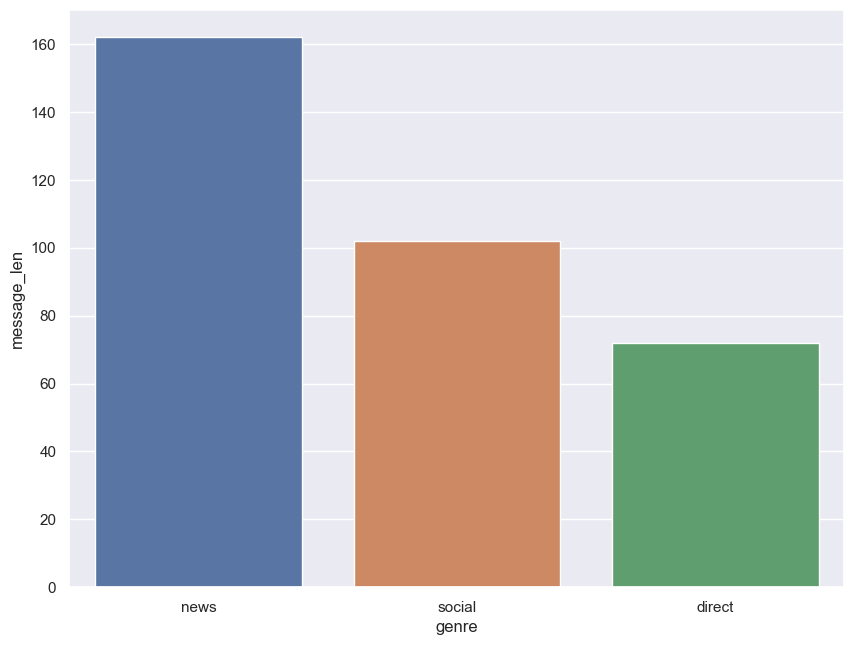

In [12]:
sns.barplot(data = plot_message_len.sort_values('message_len', ascending = False), x = 'genre', y = 'message_len')

# How do categories behave

In [13]:
cat_cols = df.columns[4:-3].to_list()

In [14]:
cat_cols

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [14]:
df[cat_cols].sum().sort_values(ascending = False)

related                   20090
aid_related               10860
weather_related            7297
direct_report              5075
request                    4474
other_aid                  3446
food                       2923
earthquake                 2455
storm                      2443
shelter                    2314
floods                     2155
medical_help               2084
infrastructure_related     1705
water                      1672
other_weather              1376
buildings                  1333
medical_products           1313
transport                  1201
death                      1194
other_infrastructure       1151
refugees                    875
military                    860
search_and_rescue           724
money                       604
electricity                 532
cold                        530
security                    471
clothing                    405
aid_centers                 309
missing_people              298
hospitals                   283
fire    

There is no data on child_alone category. Therefore it can't be predicted (there will be no training data on it).

In [15]:
df.drop(columns = 'child_alone', inplace = True)

In [16]:
cat_cols.remove('child_alone')

The classes are clearly unbalanced

## Category frequence

In [17]:
frequent_cats = df[cat_cols].sum()\
                            .sort_values(ascending = False)\
                            .head(10)

frequent_cats = frequent_cats.reset_index()

frequent_cats.rename(columns = {'index':'Category', 0:'Count'}, inplace = True)

<AxesSubplot: xlabel='Category', ylabel='Count'>

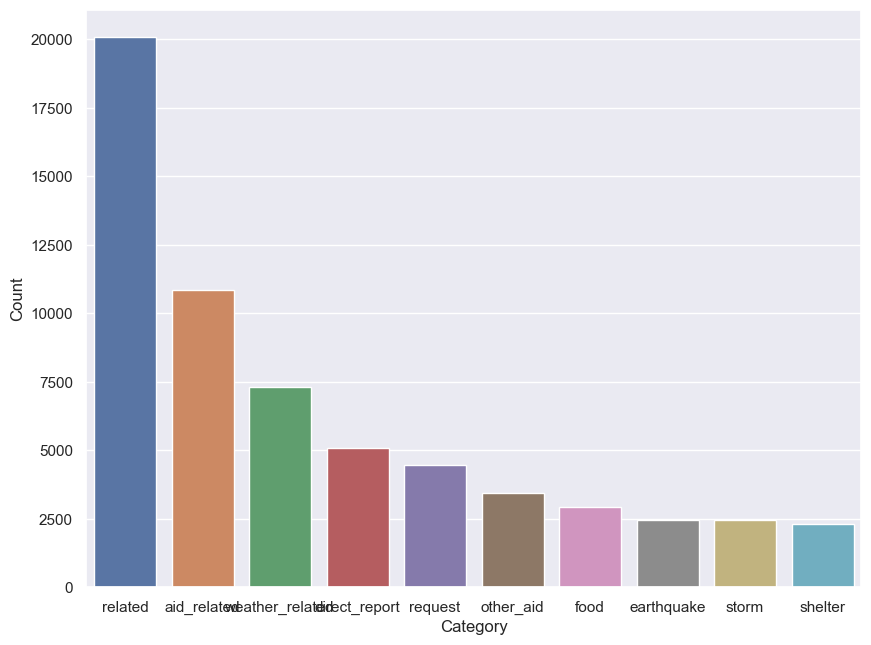

In [18]:
sns.barplot(data = frequent_cats,
            x = 'Category',
            y = 'Count')

## Can genre be useful for segregating information?

In [19]:
frequent_cats_genre = df.groupby(['genre'])[cat_cols].sum()

<AxesSubplot: xlabel='variable', ylabel='value'>

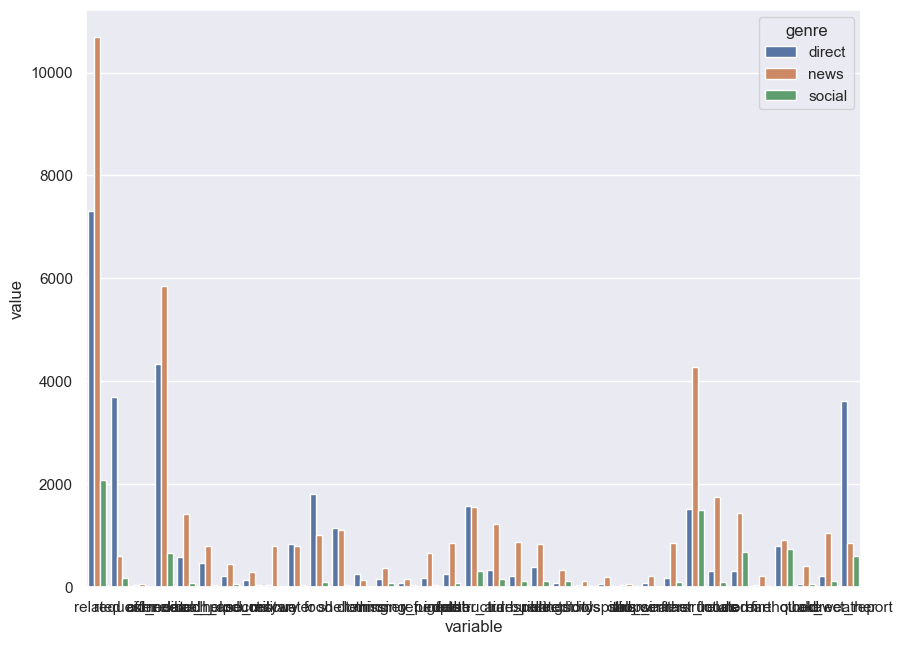

In [20]:
sns.barplot(data = frequent_cats_genre.melt(ignore_index=False).reset_index(),
            x = 'variable', y = 'value', hue='genre')

It might be, since some labels are contained in different proportions across genres

In [21]:
df[cat_cols + ['genre']].sum().drop('genre')

related                   20090
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire                        282
earthqua

In [22]:
frequent_cats = df[cat_cols + ['genre']].sum()\
                            .drop('genre')\
                            .sort_values(ascending = False)\
                            .head(10)

frequent_cats = frequent_cats.reset_index()

frequent_cats.rename(columns = {'index':'Category', 0:'Count'}, inplace = True)

<AxesSubplot: xlabel='Category', ylabel='Count'>

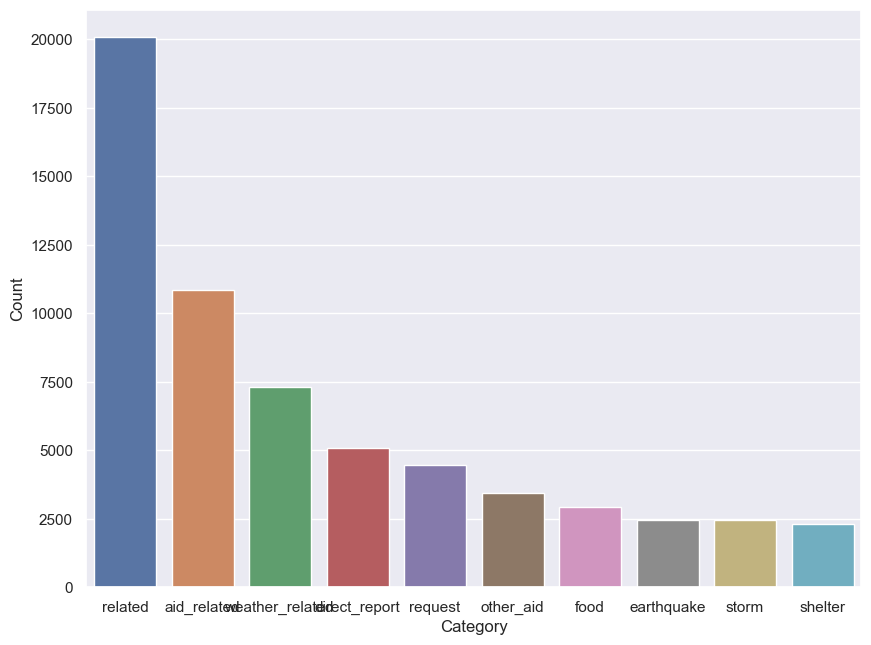

In [23]:
sns.barplot(data = frequent_cats,
            x = 'Category',
            y = 'Count')

In [24]:
phi_matrix = df[cat_cols].phik_matrix()

interval columns not set, guessing: ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [25]:
phi_matrix = phi_matrix.where(np.triu(np.ones(phi_matrix.shape)).astype(bool))

In [26]:
melted_phi_matrix = phi_matrix.melt(ignore_index = False).dropna(subset = 'value')

In [27]:
melted_phi_matrix = melted_phi_matrix[melted_phi_matrix['value'] != 1]

In [28]:
melted_phi_matrix.nlargest(10, columns = 'value')

,variable,value
infrastructure_related,other_infrastructure,0.956763
request,direct_report,0.850813
weather_related,earthquake,0.726154
weather_related,storm,0.724644
weather_related,floods,0.686480
related,aid_related,0.666207
aid_related,other_aid,0.664169
request,aid_related,0.646890
aid_related,food,0.614220
infrastructure_related,aid_centers,0.604593


In [29]:
plot_corrs = melted_phi_matrix.nlargest(10, columns = 'value').reset_index()

In [30]:
plot_corrs['label'] = plot_corrs['index']+' & '+plot_corrs['variable']

Text(0.5, 1.0, "Co-occurance of labels measured by Pearson's Rho")

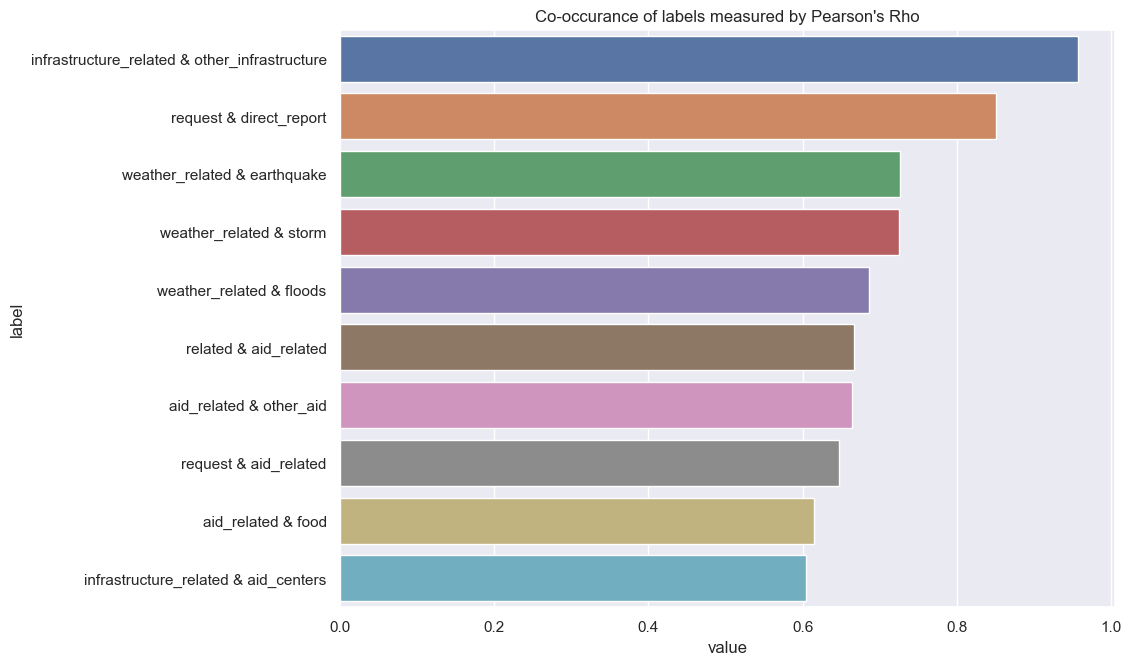

In [31]:
sns.barplot(data = plot_corrs, y = 'label', x = 'value')

plt.title("Co-occurance of labels measured by Pearson's Rho")

There is some label co-occurance, this can also be an input for modelling 

# ML Experiments

## Utils

In [32]:
en_stopwords = stopwords.words('english')

en_stopwords = [re.sub('\W','', word) for word in en_stopwords]

Note that stopwords contain contractions' apostrophes. They'll need to be removed, since our text preprocessing actually removed them from the text

In [33]:
language_filter = df['infered_language'] == 'en'

corpus_col = 'message_cleaned'

In [34]:
use_genre = True

if use_genre:

    X = df.loc[language_filter, [corpus_col, 'genre']]

    y = df.loc[language_filter, cat_cols]

else:

    X = df.loc[language_filter, corpus_col]

    y = df.loc[language_filter, cat_cols] 

In [35]:
def tokenizer(text):

    tokens = text.split(' ')

    wn = WordNetLemmatizer()

    ps = PorterStemmer()

    tokens = [token for token in tokens if token not in en_stopwords]

    tokens = [wn.lemmatize(token) for token in tokens]

    tokens = [ps.stem(token) for token in tokens]

    return tokens

## First model comparison

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [109]:
def run_pipeline(pipe, pipe_name = None, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):

    if not pipe_name:

        raise ValueError('Name the pipeline before running')

    run_datetime = datetime.now().strftime('%Y%m%d_%H%M%S')

    pipe_name = pipe_name + f'_{run_datetime}'

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    # Using micro average because of class imbalance
    scores = [score(y_test, y_pred, average='micro') for score in [f1_score, recall_score, precision_score]]

    scores.append(hamming_loss(y_test, y_pred))

    scores.append(accuracy_score(y_test, y_pred))

    result_list = [pipe_name]

    result_list.extend(scores)

    return result_list, pipe

In [110]:
full_ct = ColumnTransformer([('tfidf',TfidfVectorizer(analyzer = 'word', tokenizer = tokenizer, ngram_range= (1,1)), 'message_cleaned'),
                            ('onehot',OneHotEncoder(),['genre'])])

In [111]:
pipe1 = Pipeline([('ColumnTransformer',full_ct),
                    ('clf',RandomForestClassifier(n_jobs=-1, max_depth = 10, class_weight = 'balanced'))])

pipe2 = Pipeline([('ColumnTransformer',full_ct),
                    ('clf',MultiOutputClassifier(LogisticRegression(random_state=123,n_jobs=-1, class_weight='balanced'),n_jobs=-1))])

pipe3 = Pipeline([('ColumnTransformer',full_ct),
                    ('clf',ClassifierChain(LogisticRegression(random_state=123,n_jobs=-1, class_weight='balanced'),random_state = 123))])
 

In [112]:
pipe_list = [(pipe1,'RF'),(pipe2, 'LR_Multioutput'), (pipe3,'LR_ClassChain')]

In [113]:
for i, pipelines in enumerate(pipe_list):

    now_datetime = datetime.now().strftime('%Y%m%d_%H%M%S')

    result_list, pipeline = run_pipeline(pipe = pipelines[0], pipe_name=pipelines[1])

    if i == 0:

        list_pipes_results = [result_list]

    else:

        list_pipes_results.append(result_list)

    model_name = result_list[0]

    with open(f'../models/{model_name}.pkl', 'wb') as file:

        pickle.dump(pipeline, file)


In [114]:
result_frame = pd.DataFrame(list_pipes_results, columns = ['pipe_name','f1_score','recall','precision','hamming_loss','accuracy'])

In [115]:
result_frame

,pipe_name,f1_score,recall,precision,hamming_loss,accuracy
0,RF_20221223_200830,0.193397,0.767258,0.110643,0.581335,0.000000
1,LR_Multioutput_20221223_200848,0.627451,0.743370,0.542807,0.080183,0.182114
2,LR_ClassChain_20221223_200916,0.419407,0.764674,0.288943,0.192304,0.244265


Accuracy is not the best metric for evaluating this model, since there are so many classes, the model will hardly match exactly all of them.  
Therefore, the most appropriate metrics will be considered:
- Recall &rarr; What proportion of True Positives were correctly found?
- hamming loss &rarr; What is the fraction of wrong labels to the total number of labels  

From that standpoint, we see that the multioutput logistic regression outperformed the other two models

## Results for each category from best model
Using f1, recall and precision for each category

In [119]:
from sklearn.metrics import classification_report

In [127]:
model  = 'LR_Multioutput_20221223_200848.pkl'

with open(f'../models/{model}', 'rb') as file:

        pipe = pickle.load(file)

y_pred = pipe.predict(X_test)

pred_frame = pd.DataFrame(y_pred, columns = cat_cols)

print(classification_report(y_test, pred_frame,zero_division=0, target_names=cat_cols))

                        precision    recall  f1-score   support

               related       0.92      0.82      0.87      4959
               request       0.58      0.78      0.66      1076
                 offer       0.03      0.10      0.05        29
           aid_related       0.73      0.75      0.74      2669
          medical_help       0.39      0.67      0.49       507
      medical_products       0.32      0.67      0.43       311
     search_and_rescue       0.17      0.46      0.25       164
              security       0.09      0.28      0.14       109
              military       0.41      0.67      0.51       217
                 water       0.61      0.85      0.71       406
                  food       0.71      0.85      0.78       703
               shelter       0.58      0.81      0.68       602
              clothing       0.48      0.68      0.56       102
                 money       0.28      0.68      0.40       135
        missing_people       0.14      

Naturally, the categories with fewer entries are those who perform the worst

## Hyperparameter Tuning

In [162]:
hamming_score = make_scorer(hamming_loss, greater_is_better=False)

In [129]:
pipe

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(tokenizer=<function tokenizer at 0x000001A320EEA200>),
                                                  'message_cleaned'),
                                                 ('onehot', OneHotEncoder(),
                                                  ['genre'])])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                    n_jobs=-1,
                                                                    random_state=123),
                                       n_jobs=-1))])

In [145]:
params = {'ColumnTransformer__tfidf__ngram_range':[(1,1),(1,2),(2,2)],
            'clf__estimator__class_weight':[None,'balanced'],
            'clf__estimator__C':[0.5,1,5,10]}

In [167]:
cv = GridSearchCV(pipe, param_grid=params,scoring = hamming_score, n_jobs = -1)

In [168]:
# WARNING - THIS STEP WILL TAKE LONG TO RUN
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ColumnTransformer',
                                        ColumnTransformer(transformers=[('tfidf',
                                                                         TfidfVectorizer(tokenizer=<function tokenizer at 0x000001A320EEA200>),
                                                                         'message_cleaned'),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['genre'])])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                                           n_jobs=-1,
                                                                                           random_state=123),
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'ColumnTransformer__tfidf__ngram_range': [(1, 1),
                                                                   (1, 2),
                                                                   (2, 2)],
                         'clf__estimator__C': [0.5, 1, 5, 10],
                         'clf__estimator__class_weight': [None, 'balanced']},
             scoring=make_scorer(hamming_loss, greater_is_better=False))

In [169]:
cv.best_params_


{'ColumnTransformer__tfidf__ngram_range': (1, 2),
 'clf__estimator__C': 5,
 'clf__estimator__class_weight': None}

In [172]:
cv.best_score_

-0.051038459495549485

In [173]:
best_pipe = cv.best_estimator_

In [174]:
best_pipe

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<function tokenizer at 0x000001A320EEA200>),
                                                  'message_cleaned'),
                                                 ('onehot', OneHotEncoder(),
                                                  ['genre'])])),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=5,
                                                                    n_jobs=-1,
                                                                    random_state=123),
                                       n_jobs=-1))])

In [177]:
y_pred_best = best_pipe.predict(X_test)

In [178]:
[score(y_test, y_pred_best, average='micro') for score in [f1_score, recall_score, precision_score]]

[0.6939491219077936, 0.6270475819032761, 0.7768315516095912]

In [179]:
hamming_loss(y_test, y_pred_best)

0.05023912850943229

In [183]:
print(classification_report(y_test, y_pred_best, zero_division = 0, target_names = cat_cols))

                        precision    recall  f1-score   support

               related       0.86      0.94      0.90      4959
               request       0.76      0.63      0.69      1076
                 offer       0.00      0.00      0.00        29
           aid_related       0.72      0.76      0.74      2669
          medical_help       0.62      0.37      0.47       507
      medical_products       0.71      0.34      0.46       311
     search_and_rescue       0.82      0.14      0.24       164
              security       1.00      0.01      0.02       109
              military       0.63      0.29      0.39       217
                 water       0.77      0.62      0.69       406
                  food       0.81      0.71      0.76       703
               shelter       0.78      0.58      0.67       602
              clothing       0.72      0.33      0.46       102
                 money       0.62      0.26      0.37       135
        missing_people       0.67      

In general, for classes that have lower occurance, the recall is low, but precision is high. Still the hamming score is the highest. This indicates the most correct amount of labels overall.

In [184]:
with open('../models/LR_Multioutput_best_model.pkl','wb') as file:

    pickle.dump(best_pipe, file)